In [1]:
import os
import pathlib

import lance
import lancedb
import numpy as np
import pandas as pd
import pyarrow as pa
import tifffile
from tqdm import tqdm

In [2]:
# create the database object
uri = pathlib.Path("../../../data/objects_db").resolve()
# delete the database directory if it exists
if uri.exists():
    os.system(f"rm -rf {uri}")
db = lancedb.connect(uri)

In [3]:
# set the path to the videos
tiff_dir = pathlib.Path(
    "../../../2.cellprofiler_ic_processing/illum_directory_test/20231017ChromaLive_6hr_4ch_MaxIP/"
).resolve(strict=True)

### Get data formatted correctly

In [4]:
# get the list of tiff files in the directory
tiff_files = list(tiff_dir.glob("*.tiff"))
tiff_file_names = [file.stem for file in tiff_files]
# files to df
tiff_df = pd.DataFrame({"file_name": tiff_file_names, "file_path": tiff_files})

# split the file_path column by _ but keep the original column
tiff_df["file_name"] = tiff_df["file_name"].astype(str)
tiff_df[["Well", "FOV", "Timepoint", "Z-slice", "Channel", "illum"]] = tiff_df[
    "file_name"
].str.split("_", expand=True)
tiff_df["Well_FOV"] = tiff_df["Well"] + "_" + tiff_df["FOV"]
# drop all channels except for the first one
tiff_df = tiff_df[tiff_df["Channel"] == "C01"]
tiff_df = tiff_df.drop(columns=["Channel", "illum"])

# cast all types to string
tiff_df = tiff_df.astype(str)
# load binary data into the df of each image
tiff_df["image"] = tiff_df["file_path"].apply(lambda x: tifffile.imread(x).flatten())
# sort the df by the well, fov, timepoint, z-slice
tiff_df = tiff_df.sort_values(["Well", "FOV", "Timepoint", "Z-slice"])
tiff_df.reset_index(drop=True, inplace=True)
tiff_df.head()

,file_name,file_path,Well,FOV,Timepoint,Z-slice,Well_FOV,image
0,C-02_F0001_T0001_Z0001_C01_illumcorrect,/home/lippincm/Documents/live_cell_timelapse_a...,C-02,F0001,T0001,Z0001,C-02_F0001,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,C-02_F0001_T0002_Z0001_C01_illumcorrect,/home/lippincm/Documents/live_cell_timelapse_a...,C-02,F0001,T0002,Z0001,C-02_F0001,"[2, 5, 0, 2, 4, 1, 0, 6, 0, 5, 3, 1, 2, 7, 0, ..."
2,C-02_F0001_T0003_Z0001_C01_illumcorrect,/home/lippincm/Documents/live_cell_timelapse_a...,C-02,F0001,T0003,Z0001,C-02_F0001,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,C-02_F0001_T0004_Z0001_C01_illumcorrect,/home/lippincm/Documents/live_cell_timelapse_a...,C-02,F0001,T0004,Z0001,C-02_F0001,"[6, 4, 0, 6, 7, 2, 4, 1, 0, 2, 3, 3, 0, 0, 0, ..."
4,C-02_F0001_T0005_Z0001_C01_illumcorrect,/home/lippincm/Documents/live_cell_timelapse_a...,C-02,F0001,T0005,Z0001,C-02_F0001,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [5]:
schema = pa.schema(
    [
        pa.field("file_name", pa.string()),
        pa.field("file_path", pa.string()),
        pa.field("Well", pa.string()),
        pa.field("FOV", pa.string()),
        pa.field("Timepoint", pa.string()),
        pa.field("Z-slice", pa.string()),
        pa.field("Well_FOV", pa.string()),
        pa.field("image", pa.list_(pa.int16())),
    ]
)
tbl = db.create_table("0.original_images", schema=schema, mode="overwrite")

tbl.add(tiff_df)

[2024-08-24T01:26:53Z WARN  lance::dataset] No existing dataset at /home/lippincm/Documents/live_cell_timelapse_apoptosis/data/objects_db/0.original_images.lance, it will be created


In [6]:
df = tbl.to_pandas()
df.head()

,file_name,file_path,Well,FOV,Timepoint,Z-slice,Well_FOV,image
0,C-02_F0001_T0001_Z0001_C01_illumcorrect,/home/lippincm/Documents/live_cell_timelapse_a...,C-02,F0001,T0001,Z0001,C-02_F0001,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,C-02_F0001_T0002_Z0001_C01_illumcorrect,/home/lippincm/Documents/live_cell_timelapse_a...,C-02,F0001,T0002,Z0001,C-02_F0001,"[2, 5, 0, 2, 4, 1, 0, 6, 0, 5, 3, 1, 2, 7, 0, ..."
2,C-02_F0001_T0003_Z0001_C01_illumcorrect,/home/lippincm/Documents/live_cell_timelapse_a...,C-02,F0001,T0003,Z0001,C-02_F0001,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,C-02_F0001_T0004_Z0001_C01_illumcorrect,/home/lippincm/Documents/live_cell_timelapse_a...,C-02,F0001,T0004,Z0001,C-02_F0001,"[6, 4, 0, 6, 7, 2, 4, 1, 0, 2, 3, 3, 0, 0, 0, ..."
4,C-02_F0001_T0005_Z0001_C01_illumcorrect,/home/lippincm/Documents/live_cell_timelapse_a...,C-02,F0001,T0005,Z0001,C-02_F0001,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


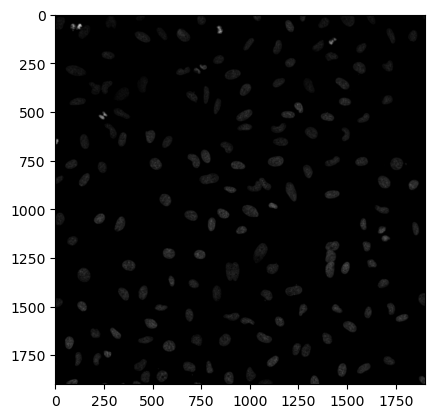

In [7]:
# load the first image
df["image"][0]
# load the binary data into a numpy array
np.frombuffer(df["image"][0], dtype=np.uint8)
# plto the image
import matplotlib.pyplot as plt

df["image"][0].reshape(1900, 1900)
plt.imshow(df["image"][0].reshape(1900, 1900), cmap="gray")
plt.show()